# Automatically Asign Signs on a Tabular Papyrus to Manually Drawn Columns

As a prehistory: The photo of the middle part of the [Demotic astronomical papyrus Pap. Berlin P 8279+23547](https://id.smb.museum/object/823520/griechisch-demotischer-papyrus-mit-getreideabrechnungen-und-sterntafeln-pap--berlin-p-8279---p-23547). This photo comprises the parts E-F on the verso of the papyrus and has been downloaded from [https://id.smb.museum/object/823520](https://recherche.smb.museum/images/69/6935950_4000x4000.jpg) and stored as [P_08279_V_002.jpg](./photos/P_08279_V_002.jpg). The corners of the photo have been marked with 21 x 21 px squares, to be able to anchor the outline of the papyrus, the signs and the boundaries relative to each other. This manipulated photo has been saved as [P_08279_V_002.jpg](./photos/P_08279_V_002.png). With the help of Inkscape the manupulated photo has been converted into a svg vector graphic. The result of this 1st step is: [P_08279_V_002_step01.svg](./svgs/P_08279_V_002_step01.svg) This svg has been cleaned up. The result of this 2nd step is: [P_08279_V_002_step02.svg](./svgs/P_08279_V_002_step02.svg) Finally, the columns have been marked on it manually. The result of this 3rd step is: [P_08279_V_002_step03.svg](./svgs/P_08279_V_002_step03.svg) In the next step the infomation which sign belongs into which column has been written into the svg. This notebook here will now automatically asign the signs to the column there are in.

## Preample

### Use the full width of the screen available

In [133]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Import necessary packages

configparser is used to easily read in the [configuration file](./config.properties). As svgs are based on xml, bs4 is used to manipulate the svg. matplotlib is a library to display graphs, it is used here to visually check the correction of the misplaced boundaries. svgpath2mpl is used to handle the svgs while shapely turns the paths from the svgs into polygons so that they can be handled in a more efficient way in Python. svg_path_transform is used to correct the misplaced boundaries.

In [134]:
import configparser
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
from svgpath2mpl import parse_path
from shapely.geometry import Polygon
import svg_path_transform as S

### Read the config file

When reading in the config the comments are ignored as well as any capitalization. The config is split into a general part and a one that is specific for each papyrus photo that is worked on. In the following the general config `configGen` may be accessed by `configGen[field]`.

In [135]:
config = configparser.RawConfigParser()
config.read('./config.properties')

configGen = dict(config.items('general'))
configPap = dict(config.items(configGen['workpap']))

## Main Part

### Open the svg and process it with bs4

Read the file to work on and the number of the step from the configs above.

In [136]:
numStep = int(configPap['numstep'])
filename = configPap['filename'] + '_step' + str(numStep).zfill(2) + '.svg'

Here the svg is opened and (as svg is based on xml) processed with bs4.

In [137]:
with open(configGen['svgdir'] + filename, 'r') as f:
    file = f.read() 
soup = bs(file, 'xml')

The next cell determines if the layer, the group of the signs, the group of the contour of the papyrus or the group of the boundaries of the columns has undergone some transformations which need to be accounted for when establish into which column each sign belongs.

In [138]:
leftmostCol = configPap['leftmostcol']

if soup.g.get('transform'):
    transformLayer = True
else:
    transformLayer = False
    
if soup.find(attrs={"inkscape:label": 'signs'}).get('transform'):
    transformSigns = True
else:
    transformSigns = False
    
if soup.find(attrs={"inkscape:label": 'boundaries'}).get('transform') or soup.find(attrs={"inkscape:label": leftmostCol}).get('transform'):
    transformBoundaries = True
else:
    transformBoundaries = False
    
if soup.find(attrs={"inkscape:label": 'contour'}).get('transform'):
    transformContour = True
else:
    transformContour = False

All column boundaries and all sign paths ({name: path}) are extracted here. The boundaries are easy to determine as their stroke color is red (color code: #ff0000). Only signs that are not hidden (like the scale or the markers which have the attribute `display:none` in the svg file) are included in the signs dictionary.

In [139]:
boundaries = {}
for element in soup.find_all('path', style=lambda x: 'stroke:#ff0000' in x):
    p = element.get('d')
    Id = element.get('inkscape:label')
    boundaries[Id] = p

In [140]:
signs = {}
for element in soup.find(attrs={"inkscape:label": "signs"}).find_all('svg:path', style=lambda x: 'display:none' not in x):
    signs[element.get('id')] = element.get('d')

### Correct the misplaced boundaries, if necessary

### Read numerical values from configs

In the following the numerical values necessary for the calculations carried out in this notebook are read from the configs and stored under short variables for quick use. An explanation of the meaning of each variable can be also found in the [configuration file](./config.properties).

In [141]:
xbrD = float(configPap['xbrd'])
ybrD = float(configPap['ybrd'])

xbr = float(configPap['xbr'])
ybr = float(configPap['ybr'])

xmrD = float(configPap['xmrd'])
ymrD = float(configPap['ymrd'])

xmr = float(configPap['xmr'])
ymr = float(configPap['ymr'])

The problem of possibly disaligned boundaries arised from the way the svg is processed here. The paths of the boundaries as well as the signs are read off the `d` tag of each corresponding path. This leaves the transformation applied to them unaccounted so far. That is why the path read of from the svg in this way might be misaligned compared to where they are located in the svg as displaced by Inkscape for example. If there is no misalignment than the upper left edge of both the upper left marker as well as the leftmost boundary should coincide at (0, 0).

In [142]:
# The position of the upper left corner of the markerUpperLeft has been determined with Inkscape, when selecting the markerUpperLeft and reading off X and Y from the top middle Inkscape window. markerUpperLeft = [X, Y]
markerUpperLeft = [xbr, ybr]

# The position of the upper left corner of the rightmost boundary has been determined with Inkscape, when selecting the rightmost boundary and reading off X and Y from the top middle Inkscape window. boundaryUpperLeft = [X, Y]
boundaryUpperLeft = [xmr, ymr]

The following graphic shows the misalignment of the signs and boundaries, if there is any.

<function matplotlib.pyplot.show(close=None, block=None)>

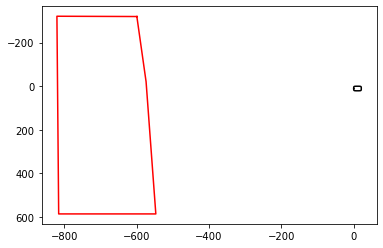

In [143]:
plt.gca().invert_yaxis()
# Marker links oben
marker = Polygon(parse_path(soup.find(attrs={"inkscape:label": 'markerUpperLeft'}).get('d')).to_polygons()[0]).exterior.xy
plt.plot(*marker, color = 'black')
# rote Boundary
boundary = Polygon(parse_path(boundaries[leftmostCol]).to_polygons()[0]).exterior.xy
plt.plot(*boundary, color = 'red')
plt.show

If the layer, the group of the boundaries or the individual boundaries bear a `transform` tag as checked above than it is necessary to correct the position of the individual column boundary paths. The two transformation that are accounted for here is a translation and a scaling.

In [144]:
if transformBoundaries == True or transformLayer == True:
    # The width and the height of the leftmost boundary path are calculated.
    xbsD = max(boundary[0]) - min(boundary[0])
    ybsD = max(boundary[1]) - min(boundary[1])
    # The scale in x and y direction is determined as the ratio between the calculated and the Inkscape measurements.
    xbscale = xbrD / xbsD
    ybscale = ybrD / ybsD
    print('boundary scale', xbscale, ybscale)

    # The position of the upper left corner of the leftmost boundary path is calculated.
    xbs = min(boundary[0])
    ybs = min(boundary[1])
    # The translation in x and y direction is determined as the difference between the calculated and the points determined with Inkscape.
    xbdisplacement = xbr - xbs
    ybdisplacement = ybr - ybs
    # The scaling factor also affects the translation and has to be included in the calculation of the final translation.
    xbdisplacement = xbdisplacement * xbscale
    ybdisplacement = ybdisplacement * ybscale
    print('boundary displacement', xbdisplacement, ybdisplacement)

boundary scale 2.191634871962688 2.1955205143231646
boundary displacement 1798.9971289094435 705.2128913249418


In [145]:
if transformSigns == True or transformLayer == True:
    # The width and the height of the upper left corner of the upper left marker are calculated.
    xmsD = max(marker[0]) - min(marker[0])
    ymsD = max(marker[1]) - min(marker[1])
    # The scale in x and y direction is determined as the ratio between the calculated and the Inkscape measurements.
    xmscale = xmrD / xmsD
    ymscale = ymrD / ymsD
    print('sign scale', xmscale, ymscale)
    
    # The position of the upper left corner of the upper left marker is calculated.
    xms = min(marker[0])
    yms = min(marker[1])
    # The translation in x and y direction is determined as the difference between the calculated and the points determined with Inkscape.
    xmdisplacement = xmr - xms
    ymdisplacement = ymr - yms
    # The scaling factor also affects the translation and has to be included in the calculation of the final translation.
    xmdisplacement = xmdisplacement * xmscale
    ymdisplacement = ymdisplacement * ymscale
    print('signs displacement', xmdisplacement, ymdisplacement)

In the following two cells the position and the scale of the boundaries as well as the signs is corrected according the the calculations above.

In [146]:
# correct position of boundaries, if necessary:
if transformBoundaries == True or transformLayer == True:
    for b in list(boundaries.keys()):
        boundaries[b] = S.path_to_string(S.translate_and_scale(S.parse_path(boundaries[b]), s=(xbscale, ybscale), t=(xbdisplacement, ybdisplacement)), sfig=8)

In [147]:
# correct position of signs, if necessary:
if transformSigns == True or transformLayer == True:
    for b in list(signs.keys()):
        signs[b] = S.path_to_string(S.translate_and_scale(S.parse_path(signs[b]), s=(xmscale, ymscale)), t=(xmdisplacement, ymdisplacement), sfig=8)

### Control alignment of signs and boundaries

<function matplotlib.pyplot.show(close=None, block=None)>

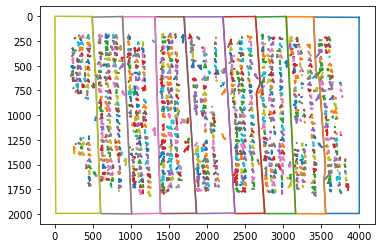

In [148]:
plt.gca().invert_yaxis()
for b in list(boundaries.keys()):
    plt.plot(*Polygon(parse_path(boundaries[b]).to_polygons()[0]).exterior.xy)
for s in list(signs.keys()):
    plt.plot(*Polygon(parse_path(signs[s]).to_polygons()[0]).exterior.xy)
plt.show

The figure above shows that the signs and the boundaries are now aligned as they are when displayed in Inkscape.

### Asign signs to boundary

The following function determines for each sign within which column boundary it is located.

In [149]:
def signInBoundary(boundaries, signs):
    signList = list(signs.keys())
    boundaryList = list(boundaries.keys())
    
    boundaryPolygons = {b: Polygon(parse_path(boundaries[b]).to_polygons()[0]) for b in boundaryList}
    signInBoundary = {}
    for s in signList:
        signPolygon = Polygon(parse_path(signs[s]).to_polygons()[0])
        signInBoundary[s] = None
        for b in boundaryList:
            if boundaryPolygons[b].contains(signPolygon):
                signInBoundary[s] = b
    return signInBoundary

In [150]:
signInBoundaries = signInBoundary(boundaries, signs)

After asigning a boundary to each sign it is check that indeed all signs are comprise of one boundary so no sign is left out. If the resulting list is not empty the boundaries have to be corrected in Inkscape and the notebook has to be run from the beginning once more.

In [151]:
inNoBoundary = [Id for Id in list(signInBoundaries.keys()) if not signInBoundaries[Id]]
inNoBoundary

[]

### Add column labels to the svg

The following cells add the boundaries that each sign is in as an attribute `column` to each sign path in the svg.

In [152]:
for s in list(signInBoundaries.keys()):
    soup.find(attrs={'id' : s})['column'] = signInBoundaries[s]

## End

### Export the modified svg

Finally, the modified svg is exported under the original directory and filename but the step number is increased by one to avoid overwriting the svg imported above.

In [153]:
with open('./svgs/' + filename.replace('_step' + str(numStep).zfill(2), '_step' + str(numStep + 1).zfill(2)), 'w') as f:
    f.write(soup.prettify())